### The purpose of this notebook to is to recreate the regress the SSH in GLORYS onto the CWI developed in Amaya et al. (2022)

In [123]:
import os
os.chdir('/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/scripts/MxLayerIndex scripts')
plotsdir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/plots/" + x
GLORYS_dir = lambda x="": "/vortexfs1/home/anthony.meza/GLORYS_data" + x
GLORYS_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/GLORYS_processed/" + x
ERA5_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/ERA5_data/" + x

In [2]:
# from help_funcs import * 
# from eofs.xarray import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import importlib
import xarray as xr
import seaborn as sns
import pandas as pd
import cmocean.cm as cm
import netCDF4 as nc
import matplotlib.pyplot as plt
import gc
import os 
import multiprocessing
from os.path import exists
sns.set_context("notebook")
import dask_labextension
from pathlib import Path
import numpy as np
import dask
# dask.config.set({"array.slicing.split_large_chunks": False})

In [138]:
def remove_seasonal(ds):
    climatology = ds.groupby("time.month").mean("time")
    anomalies = ds.groupby("time.month") - climatology
    return anomalies.drop("month")
def normalize(x):
    return (x - np.mean(x)) / np.std(x)
def corr(x, y): 
    return np.mean(normalize(x)*normalize(y))
def xcorr(x, y):
    output = plt.xcorr(normalize(x), normalize(y), maxlags=100, usevlines = False, normed=True, alpha=0.0)
    return output

In [3]:
def remove_climatology(ds, climatology):
    ds = ds.convert_calendar('noleap') #remove leap years from operations
    anomalies = ds.groupby("time.dayofyear") - climatology
    anomalies["time"] = anomalies.indexes['time'].to_datetimeindex()
    anomalies["time"] = anomalies.indexes['time'].normalize()
    return anomalies

### We read in the Amaya Coastal Wave Index Amplitude $(\text{Index} =  \sqrt{\text{PC1}^2 + \text{PC2}^2)}$ and Phase $(\text{Phase} = atan( {\frac{\text{PC2}}{\text{PC1}}}))$ and recompute $\text{PC1}$ and $\text{PC2}$. We also remove the leap-year days from the GLORYS dataset.

In [71]:
#read in Amaya Coastal wave index 
INDEX_TYPE = "S"

mxtmp_Idx = xr.open_dataset(GLORYS_data_dir("GLORYS_" + INDEX_TYPE + "_Index.nc")).sel(time = slice("1993", "2018"))
mxtmp_Idx["ikw_amp"] = np.sqrt(mxtmp_Idx["PC1"]**2 + mxtmp_Idx["PC2"]**2)

#obtain the phases from 0 to 360 degrees
#measure angle from negative (-1, 0) instead of (1, 0)
mxtmp_Idx["ikw_ph"] =  np.rad2deg(np.arctan2(mxtmp_Idx["PC2"], mxtmp_Idx["PC1"]))
mxtmp_Idx["ikw_ph"].values[mxtmp_Idx["ikw_ph"].values < 0] +=360

IDX_S = mxtmp_Idx

In [72]:
#read in Amaya Coastal wave index 
INDEX_TYPE = "SM"

mxtmp_Idx = xr.open_dataset(GLORYS_data_dir("GLORYS_" + INDEX_TYPE + "_Index.nc")).sel(time = slice("1993", "2018"))
mxtmp_Idx["ikw_amp"] = np.sqrt(mxtmp_Idx["PC1"]**2 + mxtmp_Idx["PC2"]**2)

#obtain the phases from 0 to 360 degrees
#measure angle from negative (-1, 0) instead of (1, 0)
mxtmp_Idx["ikw_ph"] =  np.rad2deg(np.arctan2(mxtmp_Idx["PC2"], mxtmp_Idx["PC1"]))
mxtmp_Idx["ikw_ph"].values[mxtmp_Idx["ikw_ph"].values < 0] +=360

IDX_SM = mxtmp_Idx

In [ ]:
sns.set_context("poster")

fig, axes = plt.subplots(figsize = (20, 5), sharey = True, sharex = True)
colors = [sns.color_palette("colorblind")[i] for i in [4, 0]]

axes.plot(IDX_S.time, IDX_S.ikw_amp.values, c= colors[1], linewidth = 3, alpha = 0.95,  label = "SSH Index")
axes.plot(IDX_SM.time, IDX_SM.ikw_amp.values, c= colors[0], linewidth = 3, alpha = 0.95, label = "SST/SSH Index")
axes.legend(loc ='upper right', ncols = 2, frameon=False, fontsize = 20, markerscale = 0.1)
axes.set_ylabel("index amplitude")
axes.set_xlabel("time")
r = np.round(corr(IDX_SM.ikw_amp, IDX_S.ikw_amp).values, 2)
axes.text(0.05, 0.9, "r = " + str(r), transform=axes.transAxes, fontsize = 20)
fig.savefig(plotsdir("generals/IndexAmplitudeswENSO.png"), bbox_inches = "tight")

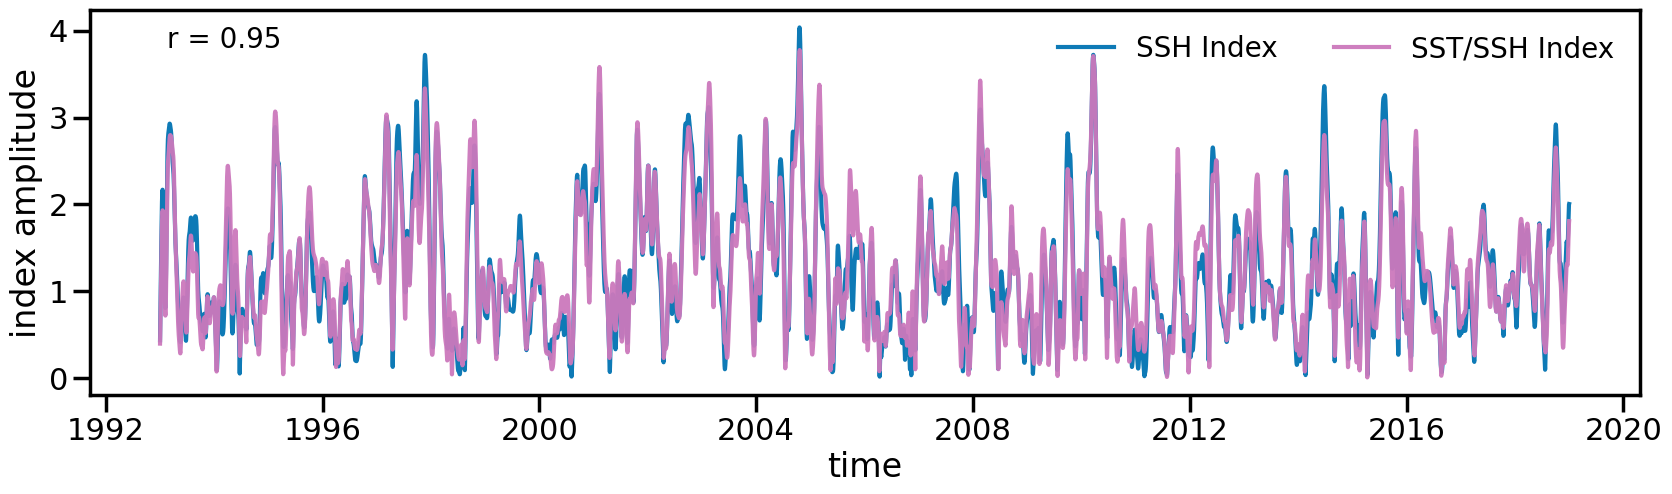

In [59]:
sns.set_context("poster")

fig, axes = plt.subplots(figsize = (20, 5), sharey = True, sharex = True)
colors = [sns.color_palette("colorblind")[i] for i in [4, 0]]

axes.plot(IDX_S.time, IDX_S.ikw_amp.values, c= colors[1], linewidth = 3, alpha = 0.95,  label = "SSH Index")
axes.plot(IDX_SM.time, IDX_SM.ikw_amp.values, c= colors[0], linewidth = 3, alpha = 0.95, label = "SST/SSH Index")
axes.legend(loc ='upper right', ncols = 2, frameon=False, fontsize = 20, markerscale = 0.1)
axes.set_ylabel("index amplitude")
axes.set_xlabel("time")
r = np.round(corr(IDX_SM.ikw_amp, IDX_S.ikw_amp).values, 2)
axes.text(0.05, 0.9, "r = " + str(r), transform=axes.transAxes, fontsize = 20)
fig.savefig(plotsdir("generals/IndexAmplitudes.png"), bbox_inches = "tight")

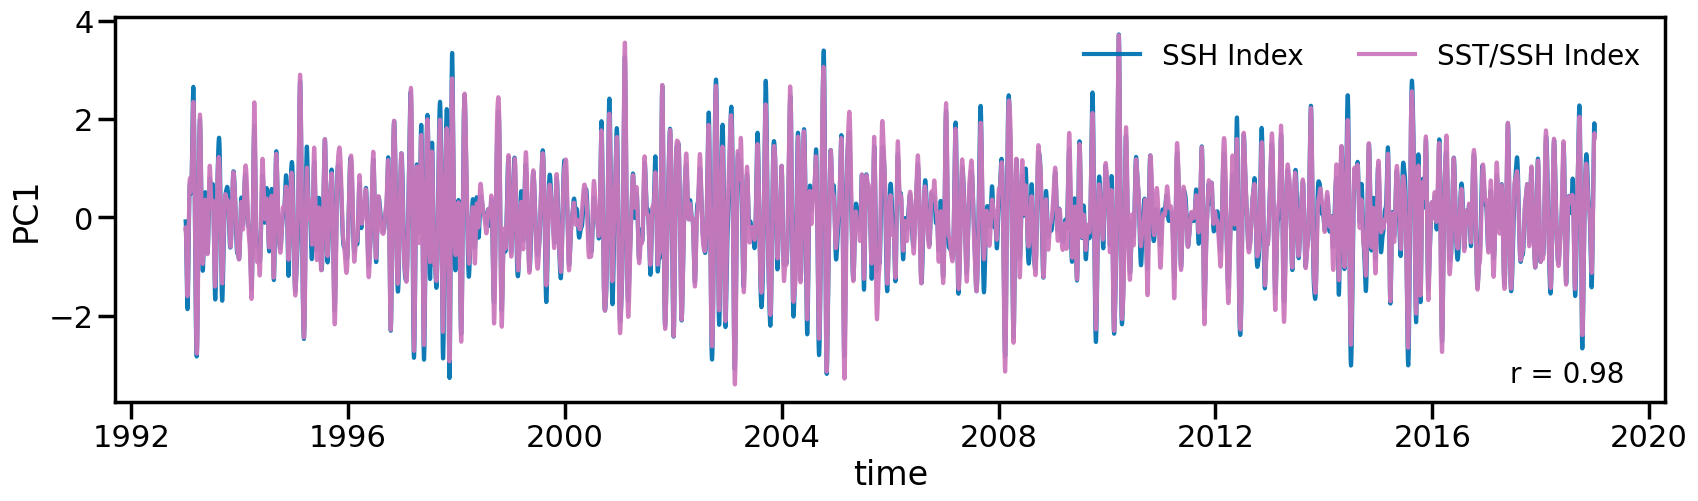

In [60]:
sns.set_context("poster")

fig, axes = plt.subplots(figsize = (20, 5), sharey = True, sharex = True)
colors = [sns.color_palette("colorblind")[i] for i in [4, 0]]

axes.plot(IDX_S.time, IDX_S.PC1.values, c= colors[1], linewidth = 3, alpha = 0.95,  label = "SSH Index")
axes.plot(IDX_SM.time, IDX_SM.PC1.values, c= colors[0], linewidth = 3, alpha = 0.95, label = "SST/SSH Index")
axes.legend(loc ='upper right', ncols = 2, frameon=False, fontsize = 20, markerscale = 0.1)
axes.set_ylabel("PC1")
axes.set_xlabel("time")
r = np.round(corr(IDX_SM.PC1, IDX_S.PC1).values, 2)
axes.text(0.9, 0.05, "r = " + str(r), transform=axes.transAxes, fontsize = 20)
fig.savefig(plotsdir("generals/IndexPC1.png"), bbox_inches = "tight")

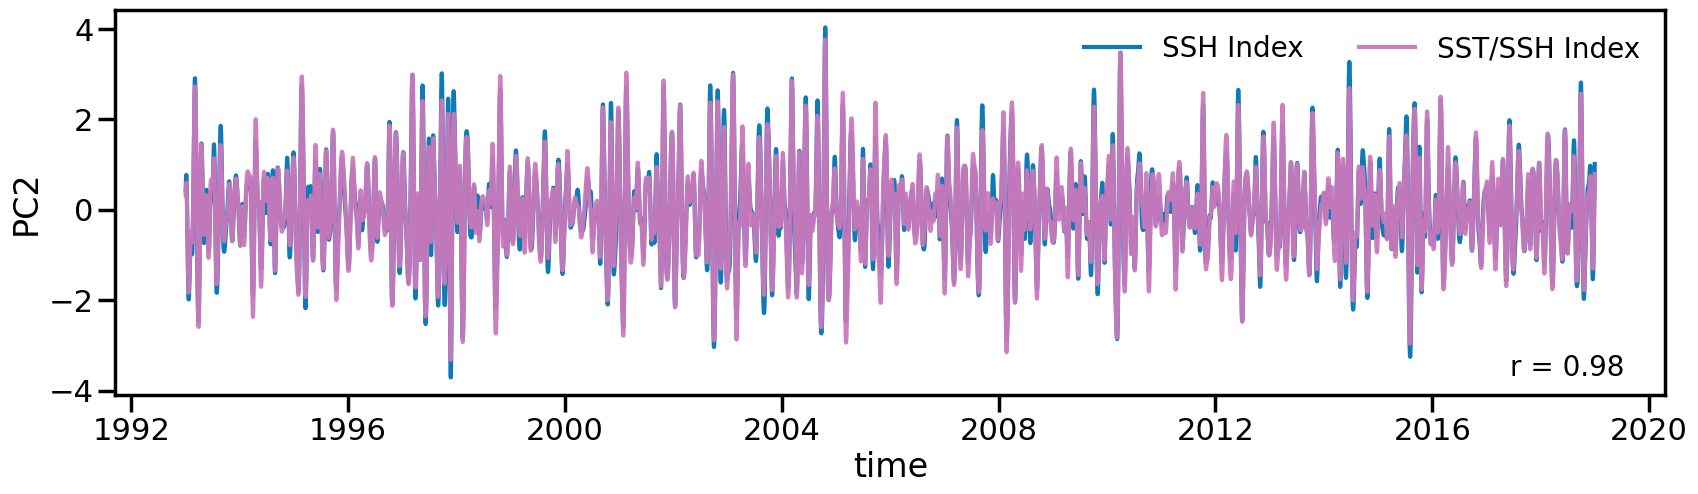

In [64]:
sns.set_context("poster")

fig, axes = plt.subplots(figsize = (20, 5), sharey = True, sharex = True)
colors = [sns.color_palette("colorblind")[i] for i in [4, 0]]

axes.plot(IDX_S.time, IDX_S.PC2.values, c= colors[1], linewidth = 3, alpha = 0.95,  label = "SSH Index")
axes.plot(IDX_SM.time, IDX_SM.PC2.values, c= colors[0], linewidth = 3, alpha = 0.95, label = "SST/SSH Index")
axes.legend(loc ='upper right', ncols = 2, frameon=False, fontsize = 20, markerscale = 0.1)
axes.set_ylabel("PC2")
axes.set_xlabel("time")
r = np.round(corr(IDX_SM.PC2, IDX_S.PC2).values, 2)
axes.text(0.9, 0.05, "r = " + str(r), transform=axes.transAxes, fontsize = 20)
fig.savefig(plotsdir("generals/IndexPC2.png"), bbox_inches = "tight")

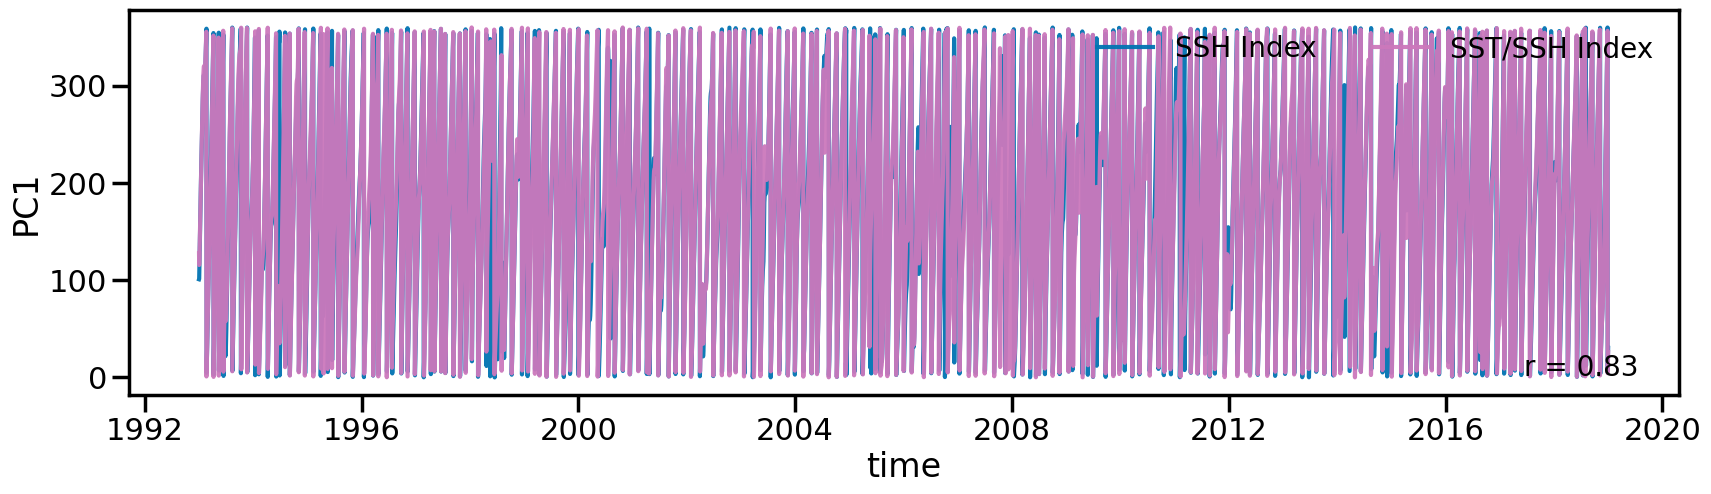

In [63]:
sns.set_context("poster")

fig, axes = plt.subplots(figsize = (20, 5), sharey = True, sharex = True)
colors = [sns.color_palette("colorblind")[i] for i in [4, 0]]

axes.plot(IDX_S.time, IDX_S.ikw_ph.values, c= colors[1], linewidth = 3, alpha = 0.95,  label = "SSH Index")
axes.plot(IDX_SM.time, IDX_SM.ikw_ph.values, c= colors[0], linewidth = 3, alpha = 0.95, label = "SST/SSH Index")
axes.legend(loc ='upper right', ncols = 2, frameon=False, fontsize = 20, markerscale = 0.1)
axes.set_ylabel("PC1")
axes.set_xlabel("time")
r = np.round(corr(IDX_SM.ikw_ph, IDX_S.ikw_ph).values, 2)
axes.text(0.9, 0.05, "r = " + str(r), transform=axes.transAxes, fontsize = 20)
fig.savefig(plotsdir("generals/IndexPhases.png"), bbox_inches = "tight")

In [124]:
df = pd.read_csv("nino34.long.csv", index_col=0)
dates_df = df.astype("datetime64[D]")
for year in range(0, len(df.index)):
    for month in range(1, len(df.columns)+1):
        dates_df.iloc[year, month - 1] = np.datetime64(pd.Timestamp(df.index[year], month, 1), "D")
NINO34_ds = xr.DataArray(
            data=df.values.flatten(),
            dims=["time"],
            coords=dict(time=dates_df.values.flatten()))
# NINO34 = NINO34_ds.sel(time = slice("1993", None))
NINO34 = remove_seasonal(NINO34_ds)
NINO34 = NINO34.interp(time=IDX_S.time, method='linear')

NINO34_EL = NINO34[NINO34 >= 1]
NINO34_LA = NINO34[NINO34 <= -1]

/tmp/ipykernel_424380/4014709609.py:6: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  NINO34_ds = xr.DataArray(


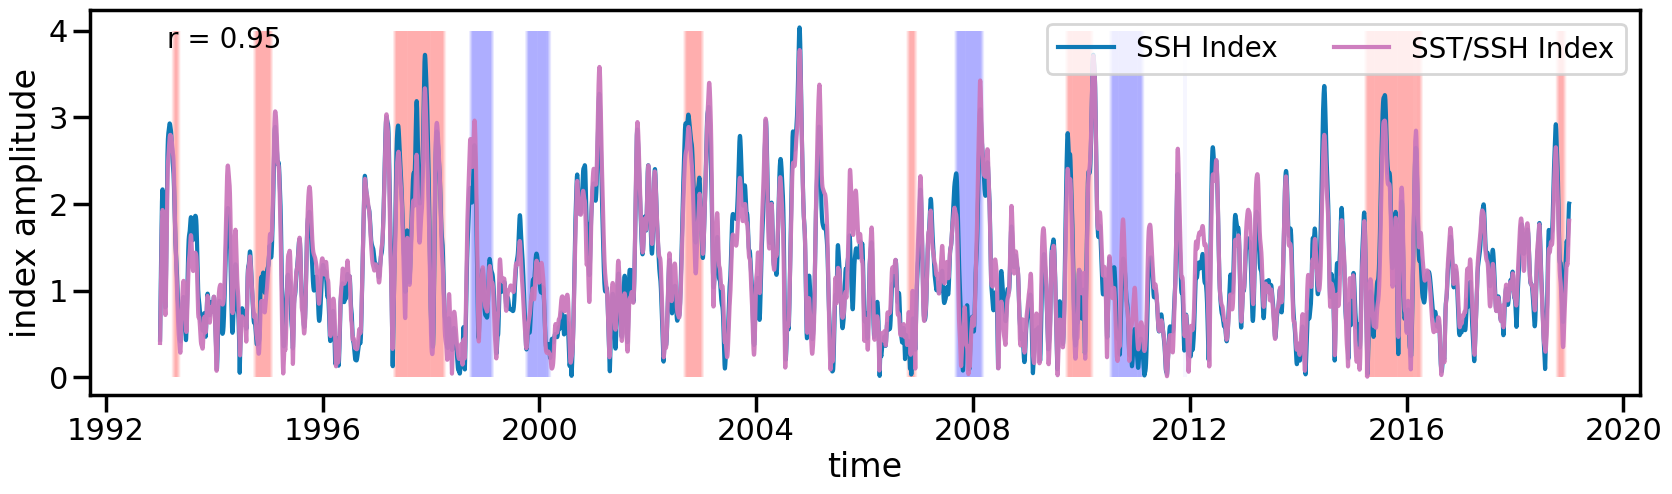

In [164]:
sns.set_context("poster")

fig, axes = plt.subplots(figsize = (20, 5), sharey = True, sharex = True)
colors = [sns.color_palette("colorblind")[i] for i in [4, 0]]

axes.vlines(NINO34_EL.time, ymin=0, ymax=4, colors='red', alpha = 0.01)
axes.vlines(NINO34_LA.time, ymin=0, ymax=4, colors='blue', alpha = 0.01)

axes.plot(IDX_S.time, IDX_S.ikw_amp.values, c= colors[1], linewidth = 3, alpha = 0.95,  label = "SSH Index")
axes.plot(IDX_SM.time, IDX_SM.ikw_amp.values, c= colors[0], linewidth = 3, alpha = 0.95, label = "SST/SSH Index")
axes.legend(loc ='upper right', ncols = 2, frameon=True, fontsize = 20, markerscale = 0.1)
axes.set_ylabel("index amplitude")
axes.set_xlabel("time")
r = np.round(corr(IDX_SM.ikw_amp, IDX_S.ikw_amp).values, 2)
axes.text(0.05, 0.9, "r = " + str(r), transform=axes.transAxes, fontsize = 20)
fig.savefig(plotsdir("generals/IndexAmplitudes_ENSO.png"), bbox_inches = "tight")


In [161]:
import pandas as pd
rmm = pd.read_csv("rMII_index_latest.txt", delim_whitespace=True)
new_rmm = rmm.iloc[:, 3:]
new_rmm["time"] = pd.to_datetime(rmm.iloc[:, 0:3].astype("string").apply("-".join, axis=1))
rmm = new_rmm.rename(columns={new_rmm.columns[0]: "PC1", 
                       new_rmm.columns[1]: "PC2",
                       new_rmm.columns[2]: "Phase"})
rmm["Amplitude"] = np.sqrt(rmm["PC1"]**2 + rmm["PC2"]**2)
rmm = rmm.set_index("time")
rmm = rmm.to_xarray().isel(time = np.where(~np.isnan(rmm.Amplitude))[0])
rmm = rmm.sel(time = slice("1993", "2018"))
rmm = rmm.convert_calendar('noleap')
rmm["time"] = rmm.indexes['time'].to_datetimeindex()
rmm["time"] = rmm.indexes['time'].normalize()
rmm_pos = rmm.Amplitude[rmm.Amplitude > 1.0]

/tmp/ipykernel_424380/3333009955.py:13: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  rmm["time"] = rmm.indexes['time'].to_datetimeindex()


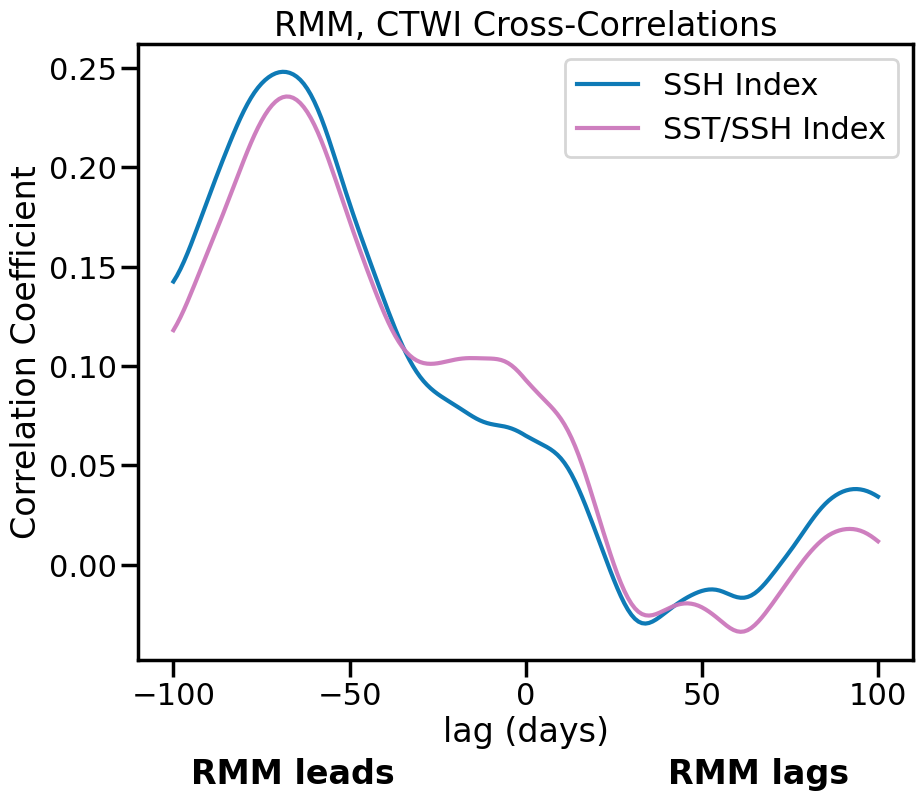

In [163]:
fig, axes = plt.subplots(1, 1, figsize = (10, 8))
output = xcorr(rmm.Amplitude, IDX_S.ikw_amp)
# output = axes.xcorr(, maxlags=100, usevlines = False, normed=True, alpha=0.0)
axes.plot(output[0], output[1], c= colors[1], linewidth = 3, alpha = 0.95,  label = "SSH Index")
output = xcorr(rmm.Amplitude, IDX_SM.ikw_amp)
axes.plot(output[0], output[1], c= colors[0], linewidth = 3, alpha = 0.95, label = "SST/SSH Index")
axes.set_title("RMM, CTWI Cross-Correlations")
axes.text(0.2, -0.2, "RMM leads", 
                  transform=axes.transAxes, horizontalalignment = "center", fontweight = "bold")
axes.text(0.8, -0.2, "RMM lags", 
                  transform=axes.transAxes, horizontalalignment = "center", fontweight = "bold")
axes.set_xlabel("lag (days)")
axes.set_ylabel("Correlation Coefficient")
axes.legend()
fig.savefig(plotsdir("generals/IndexAmplitudes_MJO_xcorr.png"), bbox_inches = "tight")
